In [29]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

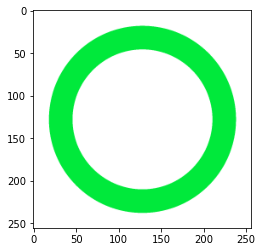

In [30]:
# loading in a standard image
J = cv2.imread('o.png')
I = cv2.cvtColor(J, cv2.COLOR_BGR2RGB)
plt.imshow(I)

In [31]:
def max_message_length(I: np.ndarray) -> int:
    return (get_image_volume_optimum(I) - get_image_data_volume_bit_len(I)) // 8


def get_image_data_volume_bit_len(I: np.ndarray) -> int:
    return int(np.ceil(np.log2(get_image_volume_optimum(I) / 8)))


def get_image_volume_optimum(I: np.ndarray) -> int:
    """:returns the number of bits of information we can store in an image"""
    return 2 * np.prod(I.shape)

In [32]:
# so for the above image, we can have the following data storage
number_of_bits_required_for_storing_the_len = get_image_data_volume_bit_len(I)
number_of_bits_for_data = get_image_volume_optimum(I) 
maximum_plaintext_length = max_message_length(I)
print('number of bits required for storing the length:', number_of_bits_required_for_storing_the_len)
print('number of bits for data:', number_of_bits_for_data)
print('maximum length of plaintext we can store in image:', maximum_plaintext_length)

number of bits required for storing the length: 16
number of bits for data: 393216
maximum length of plaintext we can store in image: 49150


In [33]:
# We now take a plaintext message which we will add in our image
plaintext = 'malavika ttttt'

In [34]:
def int_to_bin(number: int, length=8) -> str:
    b = bin(number)[2:]
    return ('0' * (-len(b) % length)) + b

In [35]:
number = 78
print(int_to_bin(number))

01001110


In [36]:
number = 100
print(int_to_bin(number, length=10))

0001100100


In [37]:
def bin_to_int(number: str) -> int:
    return int(number, base=2)

In [38]:
print(bin_to_int('001010111'))

87


In [39]:
print(bin_to_int('0001111111011'))

1019


In [40]:
def get_bit_stream_from_plaintext(plaintext: str) -> list:
    stream = []
    for letter in plaintext:
        letter_bin = int_to_bin(ord(letter))
        for bit in letter_bin:
            stream.append(bit)
    return stream

In [41]:
def add_bit_stream_to_color_channel(stream: list, C: list, start_point: int, position=7) -> None:
    for i, bit in enumerate(stream):
        pixel_bin = int_to_bin(C[i + start_point])
        pixel_bin = pixel_bin[0:position] + bit + pixel_bin[position + 1:]
        C[i + start_point] = bin_to_int(pixel_bin)

In [42]:
def get_channel_stream(I) -> list:
    B, R, G = np.ravel(I[:, :, 0]).tolist(), np.ravel(I[:, :, 2]).tolist(), np.ravel(I[:, :, 1]).tolist()
    return B + R + G

In [43]:
# We create functions to add the message in the bit stream of the image
def lsb_encrypt(I, plaintext: str):
    image_shape = I.shape[0:2]
    C = get_channel_stream(I)
    plaintext_len_bit_size = get_image_data_volume_bit_len(I)
    plaintext_len_bin = int_to_bin(len(plaintext), length=plaintext_len_bit_size)

    # adding length bits to the image
    for i in range(plaintext_len_bit_size):
        pixel_bin = int_to_bin(C[i])
        pixel_bin = pixel_bin[0:7] + plaintext_len_bin[i]
        C[i] = bin_to_int(pixel_bin)

    # creating bit stream from plaintext
    stream = get_bit_stream_from_plaintext(plaintext)

    # adding the plaintext stream to the channel stream
    add_bit_stream_to_color_channel(stream[:np.prod(I.shape) - plaintext_len_bit_size], C, start_point=plaintext_len_bit_size, position=7)
    add_bit_stream_to_color_channel(stream[(np.prod(I.shape) - plaintext_len_bit_size):], C, start_point=0, position=6)

    B, R, G = C[:len(C) // 3], C[len(C) // 3: 2 * len(C) // 3], C[2 * len(C) // 3:]
    B = np.array(B).reshape(image_shape)
    R = np.array(R).reshape(image_shape)
    G = np.array(G).reshape(image_shape)

    # Adding the pixel layers back to the Image
    I[:, :, 0] = B
    I[:, :, 2] = R
    I[:, :, 1] = G
    return I

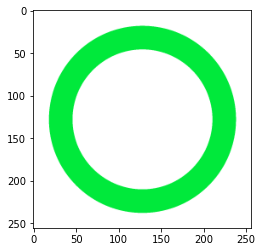

In [44]:
R = lsb_encrypt(I, plaintext)
plt.imshow(R)

In [45]:
def get_stream_from_channel(channel: list, position: int) -> list:
    stream = []
    for pixel in channel:
        pixel_bin = int_to_bin(pixel, length=8)
        pixel_bit = pixel_bin[position]
        stream.append(pixel_bit)
    return stream

In [46]:
def plaintext_from_bit_stream(stream: list) -> str:
    plaintext = ''
    for i in range(len(stream) // 8):
        byte = ''.join(stream[8 * i: 8 * i + 8])
        letter = bin_to_int(byte)
        plaintext += chr(letter)
    return plaintext

In [47]:
def lsb_decrypt(I) -> str:
    # Obtaining the B G R channel stream
    C = get_channel_stream(I)
    plaintext_len_bit_size = get_image_data_volume_bit_len(I)
    plaintext_len_bin = ''.join([int_to_bin(C[i])[7] for i in range(plaintext_len_bit_size)])
    plaintext_len = bin_to_int(plaintext_len_bin)

    # creating the bit stream from the plaintext_len
    stream = get_stream_from_channel(channel=C, position=7) + get_stream_from_channel(channel=C, position=6)
    stream = stream[plaintext_len_bit_size:plaintext_len_bit_size + plaintext_len * 8]

    # creating plaintext from bit stream
    plaintext = plaintext_from_bit_stream(stream)
    return plaintext

In [48]:
message = lsb_decrypt(R)
print('decrypted', message)

decrypted malavika ttttt


In [25]:
def random_string(length=8):
    return ''.join([chr(random.randint(0, 127)) for _ in range(length)])

In [26]:
plaintext = random_string(max_message_length(I))

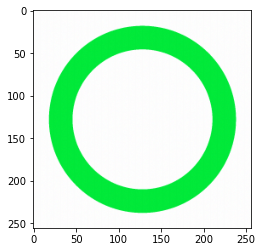

In [27]:
J = lsb_encrypt(I, plaintext)
decrypted = lsb_decrypt(J)
# the encrypted image is
plt.imshow(J)

In [28]:
# did we correctly extract the data?
print(decrypted == plaintext)

True
